# Logistic Regression Model for Elimination Prediction

This notebook implements the Logistic Regression model associated with the MCM Problem C task.
The model predicts the probability of elimination $P(\text{Eliminated}_i(w))$ based on judge scores, hidden fan votes, and other covariates.

## Model Specification

$$
P(\text{Eiiminated}_i(w)) = \frac{1}{1 + e^{-(\beta_0 + \beta_j \cdot j_{i}(w) + \beta_v \cdot v_{i}(w) + \mathbf{\beta}_{cov} \cdot \mathbf{X}_i)}}
$$

Where:
- $j_i(w)$ is the Judge Score.
- $v_i(w)$ is the Hidden Fan Vote.
- $\mathbf{X}_i$ are other covariates (Partner, Industry, Home State/Country, Age).
- Constraints: $\beta_j < 0, \beta_v < 0$.

Objective: Maximize Likelihood $L = \prod P^{y} (1-P)^{1-y}$ (or Minimize Negative Log-Likelihood).

In [86]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import sklearn.preprocessing as preprocessing
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# 1. Load Data
file_path = '2026_MCM_Problem_C_Data.csv'
df = pd.read_csv(file_path)

print("Data Loaded. Shape:", df.shape)
df.head()

Data Loaded. Shape: (421, 53)


,celebrity_name,ballroom_partner,celebrity_industry,celebrity_homestate,celebrity_homecountry/region,celebrity_age_during_season,season,results,placement,week1_judge1_score,...,week9_judge3_score,week9_judge4_score,week10_judge1_score,week10_judge2_score,week10_judge3_score,week10_judge4_score,week11_judge1_score,week11_judge2_score,week11_judge3_score,week11_judge4_score
0,John O'Hurley,Charlotte Jorgensen,Actor/Actress,Maine,United States,50,1,2nd Place,2,7.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Kelly Monaco,Alec Mazo,Actor/Actress,Pennsylvania,United States,29,1,1st Place,1,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Evander Holyfield,Edyta Sliwinska,Athlete,Alabama,United States,42,1,Eliminated Week 3,5,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Rachel Hunter,Jonathan Roberts,Model,NaN,New Zealand,35,1,Eliminated Week 4,4,7.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Joey McIntyre,Ashly DelGrosso,Singer/Rapper,Massachusetts,United States,32,1,3rd Place,3,7.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [87]:
# 2. Data Preprocessing
import re

def clean_partner_name(name):
    if pd.isna(name):
        return "Unknown"
    name = str(name).strip()
    # Remove text inside parentheses e.g., "Name (Week 9)" -> "Name"
    name = re.sub(r'\s*\(.*\)', '', name)
    # Handle slashes? Usually keep first or treat as unique combo. 
    return name.strip()

def preprocess_data(df):
    # 1. Reshape to Long Format
    long_data = []
    
    # Identify max weeks
    week_cols = [c for c in df.columns if 'week' in c and 'judge' in c]
    # Extract week numbers
    weeks = sorted(list(set([int(c.split('_')[0].replace('week','')) for c in week_cols])))
    
    for _, row in df.iterrows():
        name = row['celebrity_name']
        
        # Clean Partner Name
        raw_partner = row['ballroom_partner']
        clean_partner = clean_partner_name(raw_partner)
        
        # Static covariates
        static_feats = {
            'celebrity_name': name,
            'partner': clean_partner, # Use cleaned name
            'industry': row['celebrity_industry'],
            'homestate': row['celebrity_homestate'],
            'region': row.get('celebrity_homecountry/region', row.get('celebrity_homecountry', 'Unknown')),
            'age': row['celebrity_age_during_season'],
            'season': row['season']
        }
        
        # Determine elimination week
        result = str(row['results'])
        elim_week = -1
        if 'Eliminated Week' in result:
            try:
                elim_week = int(result.split('Week')[1].strip())
            except:
                pass
        
        for w in weeks:
            # Check if scores exist
            # Scores are usually 'weekX_judgeY_score'
            # Sum them up
            current_week_score = 0
            valid_score = False
            for j in range(1, 5): # Judges 1 to 4
                col = f"week{w}_judge{j}_score"
                if col in df.columns:
                    val = row[col]
                    # Handle N/A
                    if pd.notna(val) and str(val).strip() != 'N/A' and str(val).strip() != '':
                        try:
                            current_week_score += float(val)
                            valid_score = True
                        except:
                            pass
            
            if valid_score:
                # Determine target y
                # y = 1 if Eliminated THIS week
                # y = 0 otherwise
                is_eliminated = 1 if (w == elim_week) else 0
                
                # Add row
                data_row = static_feats.copy()
                data_row['week'] = w
                data_row['judge_score'] = current_week_score
                data_row['is_eliminated'] = is_eliminated
                # Initial guess for v (hidden)
                data_row['v_hidden'] = 0.0 
                
                long_data.append(data_row)

    df_long = pd.DataFrame(long_data)
    
    # 2. Encode Categorical Variables
    # Fill NA
    df_long.fillna('Unknown', inplace=True)
    
    # Reduce Cardinality for Partner & State?
    # Retain top 20 partners, others -> 'Other'
    top_partners = df_long['partner'].value_counts().nlargest(20).index
    df_long['partner_grouped'] = df_long['partner'].apply(lambda x: x if x in top_partners else 'Other')

    top_industries = df_long['industry'].value_counts().nlargest(10).index
    df_long['industry_grouped'] = df_long['industry'].apply(lambda x: x if x in top_industries else 'Other')
    
    # One-Hot Encoding
    # We use grouped columns to avoid dimensionality explosion
    cat_cols_to_encode = ['partner_grouped', 'industry_grouped', 'homestate', 'region']
    df_encoded = pd.get_dummies(df_long, columns=cat_cols_to_encode, drop_first=True)
    
    # Ensure age is numeric
    df_encoded['age'] = pd.to_numeric(df_encoded['age'], errors='coerce').fillna(0)
    
    return df_long, df_encoded

df_long, df_encoded = preprocess_data(df)
print(f"Processed Long Data: {df_encoded.shape}")
print("Sample Partners:", df_long['partner'].unique()[:10])
df_encoded.head()

Processed Long Data: (4199, 109)
Sample Partners: ['Charlotte Jorgensen' 'Alec Mazo' 'Edyta Sliwinska' 'Jonathan Roberts'
 'Ashly DelGrosso' 'Louis van Amstel' 'Nick Kosovich' 'Maksim Chmerkoskiy'
 'Tony Dovolani' 'Anna Trebunskaya']


,celebrity_name,partner,industry,age,season,week,judge_score,is_eliminated,v_hidden,partner_grouped_Anna Trebunskaya,...,region_Poland,region_Russia,region_South Africa,region_South Korea,region_Spain,region_Taiwan China,region_United States,region_Venezuela,region_Wales,region_Yugoslavia
0,John O'Hurley,Charlotte Jorgensen,Actor/Actress,50,1,1,20.0,0,0.0,False,...,False,False,False,False,False,False,True,False,False,False
1,John O'Hurley,Charlotte Jorgensen,Actor/Actress,50,1,2,26.0,0,0.0,False,...,False,False,False,False,False,False,True,False,False,False
2,John O'Hurley,Charlotte Jorgensen,Actor/Actress,50,1,3,24.0,0,0.0,False,...,False,False,False,False,False,False,True,False,False,False
3,John O'Hurley,Charlotte Jorgensen,Actor/Actress,50,1,4,21.0,0,0.0,False,...,False,False,False,False,False,False,True,False,False,False
4,John O'Hurley,Charlotte Jorgensen,Actor/Actress,50,1,5,27.0,0,0.0,False,...,False,False,False,False,False,False,True,False,False,False


In [88]:
# 3. Model Definition: Logistic Regression with Estimated Fan Votes

# This section has been updated to use the results from our Monte Carlo simulation.
# Instead of inferring 'v' (fan votes) as a latent variable, we use the 'Est_Fan_Support' 
# calculated in the previous step (Analysis_MCM_Problem_C).

import statsmodels.api as sm

# 1. Load Estimated Fan Votes
votes_df = pd.read_csv('estimated_fan_votes.csv')
print(f"Loaded Estimated Fan Votes: {votes_df.shape}")

# 2. Merge with Training Data
# Ensure keys match (Case sensitivity or type)
df_encoded['season'] = df_encoded['season'].astype(int)
df_encoded['week'] = df_encoded['week'].astype(int)
votes_df['Season'] = votes_df['Season'].astype(int)
votes_df['Week'] = votes_df['Week'].astype(int)

# Rename to match
votes_df = votes_df.rename(columns={'Season': 'season', 'Week': 'week', 'Contestant': 'celebrity_name'})

# Merge
df_merged = pd.merge(df_encoded, votes_df[['season', 'week', 'celebrity_name', 'Est_Fan_Support', 'Est_Fan_Uncertainty']], 
                     on=['season', 'week', 'celebrity_name'], how='left')

# Drop rows where we don't have fan estimates (if any)
len_before = len(df_merged)
df_merged = df_merged.dropna(subset=['Est_Fan_Support'])
print(f"Merged Data. Rows retained: {len(df_merged)} / {len_before}")

# 3. Prepare Feature Matrix for Logistic Regression
# We want to predict 'is_eliminated'

# Standardization
# Standardize Judge Score and Age for coefficient comparison
scaler = preprocessing.StandardScaler()
df_merged['Judge_Score_Std'] = scaler.fit_transform(df_merged[['judge_score']])
df_merged['Age_Std'] = scaler.fit_transform(df_merged[['age']])
# Fan Support is already a pct/score (0-1), but standardization helps compare magnitude with Judge Score
df_merged['Fan_Support_Std'] = scaler.fit_transform(df_merged[['Est_Fan_Support']])

# Select Features
# Core Game Mechanics: Judge Score, Fan Support
# User Characteristics: Age
# Context: Partner, Industry (One-Hot Encoded)

exclude_cols = ['celebrity_name', 'season', 'week', 'is_eliminated', 'v_hidden', 'judge_score', 
                'results', 'partner', 'industry', 'homestate', 'region', 'partner_grouped', 'industry_grouped',
                'age', 'judge_score_scaled', 'age_scaled', 'inferred_fan_vote_v', 'pred_prob_elim',
                'Est_Fan_Support', 'Est_Fan_Uncertainty', 'Score_Group']

# Identify one-hot columns
one_hot_cols = [c for c in df_merged.columns if 'partner_grouped_' in c or 'industry_grouped_' in c]

feature_cols = ['Judge_Score_Std', 'Fan_Support_Std', 'Age_Std'] + one_hot_cols

X = df_merged[feature_cols]
y = df_merged['is_eliminated']

# CRITICAL FIX: Ensure all data is numeric (float)
# Boolean True/False -> 1.0/0.0
X = X.astype(float)
y = y.astype(float)

# Add Constant for Intercept
X = sm.add_constant(X)

# 4. Train Logistic Regression Model (GLM)
try:
    # We use GLM with Binomial family (Logistic Regression)
    # Using a robust covariance type to handle potential heteroscedasticity or outliers
    model = sm.Logit(y, X).fit(disp=False)
    
    print("\n--- Logistic Regression Results (Impact Analysis) ---")
    print(model.summary())
    
    # Extract significant coefficients
    p_values = model.pvalues
    significant = p_values[p_values < 0.1].sort_values()
    print("\n--- Significant Factors (p < 0.1) ---")
    print(significant)
    
    # Save Prediction for validation
    df_merged['prob_elimination'] = model.predict(X)
    
except Exception as e:
    print(f"Error training model: {e}")


Loaded Estimated Fan Votes: (2777, 8)
Merged Data. Rows retained: 2777 / 4199

--- Logistic Regression Results (Impact Analysis) ---
                           Logit Regression Results                           
Dep. Variable:          is_eliminated   No. Observations:                 2777
Model:                          Logit   Df Residuals:                     2743
Method:                           MLE   Df Model:                           33
Date:                Fri, 30 Jan 2026   Pseudo R-squ.:                 0.08022
Time:                        12:47:52   Log-Likelihood:                -868.67
converged:                       True   LL-Null:                       -944.43
Covariance Type:            nonrobust   LLR p-value:                 4.073e-17
                                                coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
const          

In [89]:
# 4. Results Analysis & Export

# Extract Coefficients from the statsmodels result
params = model.params
conf = model.conf_int()
conf.columns = ['CI_Lower', 'CI_Upper']
pvals = model.pvalues

coef_df = pd.DataFrame({'Coefficient': params, 'P_Value': pvals})
coef_df = coef_df.join(conf)
coef_df['Odds_Ratio'] = np.exp(coef_df['Coefficient'])

print("--- Model Coefficients (Impact Factors) ---")
# Sort by significance (P-value)
display(coef_df.sort_values('P_Value').head(15))

# Save Results
coef_df.to_csv('model_coefficients.csv')
df_merged.to_csv('data_with_probabilities.csv', index=False)
print("\nSaved coefficients to 'model_coefficients.csv'")
print("Saved augmented data to 'data_with_probabilities.csv'")

# --- Interpretation ---
print("\n--- Key Interpretations ---")
def interpret_feature(name):
    if name == 'const': return
    if name not in coef_df.index: return
    
    beta = coef_df.loc[name, 'Coefficient']
    p = coef_df.loc[name, 'P_Value']
    
    if p > 0.1: return # Not significant
    
    impact = "Increases" if beta > 0 else "Decreases"
    magnitude = np.exp(beta)
    
    # Note: Target is 'is_eliminated' (1 = Eliminated)
    # So Beta > 0 means Higher Risk of Elimination
    # Beta < 0 means Safer
    
    meaning = "Risk of Elimination"
    if beta < 0:
        factor = 1/magnitude
        print(f"Feature '{name}': Significantly REDUCES {meaning} by factor of {factor:.2f}x (p={p:.4f})")
    else:
        print(f"Feature '{name}': Significantly INCREASES {meaning} by factor of {magnitude:.2f}x (p={p:.4f})")

print("Checking significant impacts:")
interpret_feature('Judge_Score_Std')
interpret_feature('Fan_Support_Std')
interpret_feature('Age_Std')
# Check a few partners/industries
for idx in coef_df.index:
    if 'partner' in idx or 'industry' in idx:
        interpret_feature(idx)


--- Model Coefficients (Impact Factors) ---


,Coefficient,P_Value,CI_Lower,CI_Upper,Odds_Ratio
Fan_Support_Std,-0.825912,7.433063e-12,-1.062259,-0.589565,0.437835
const,-2.840272,4.660540e-09,-3.790427,-1.890116,0.058410
Age_Std,0.326115,2.782326e-06,0.189722,0.462508,1.385575
industry_grouped_Model,0.892846,6.474808e-03,0.250125,1.535567,2.442070
Judge_Score_Std,0.122704,1.013486e-01,-0.024087,0.269496,1.130550
partner_grouped_Edyta Sliwinska,0.935530,1.261458e-01,-0.263313,2.134372,2.548563
partner_grouped_Louis van Amstel,0.900873,1.315455e-01,-0.269974,2.071720,2.461751
partner_grouped_Other,0.649155,1.836085e-01,-0.307674,1.605984,1.913923
partner_grouped_Karina Smirnoff,0.693538,2.165232e-01,-0.406382,1.793458,2.000782
partner_grouped_Anna Trebunskaya,0.754570,2.176486e-01,-0.445077,1.954217,2.126697



Saved coefficients to 'model_coefficients.csv'
Saved augmented data to 'data_with_probabilities.csv'

--- Key Interpretations ---
Checking significant impacts:
Feature 'Fan_Support_Std': Significantly REDUCES Risk of Elimination by factor of 2.28x (p=0.0000)
Feature 'Age_Std': Significantly INCREASES Risk of Elimination by factor of 1.39x (p=0.0000)
Feature 'industry_grouped_Model': Significantly INCREASES Risk of Elimination by factor of 2.44x (p=0.0065)


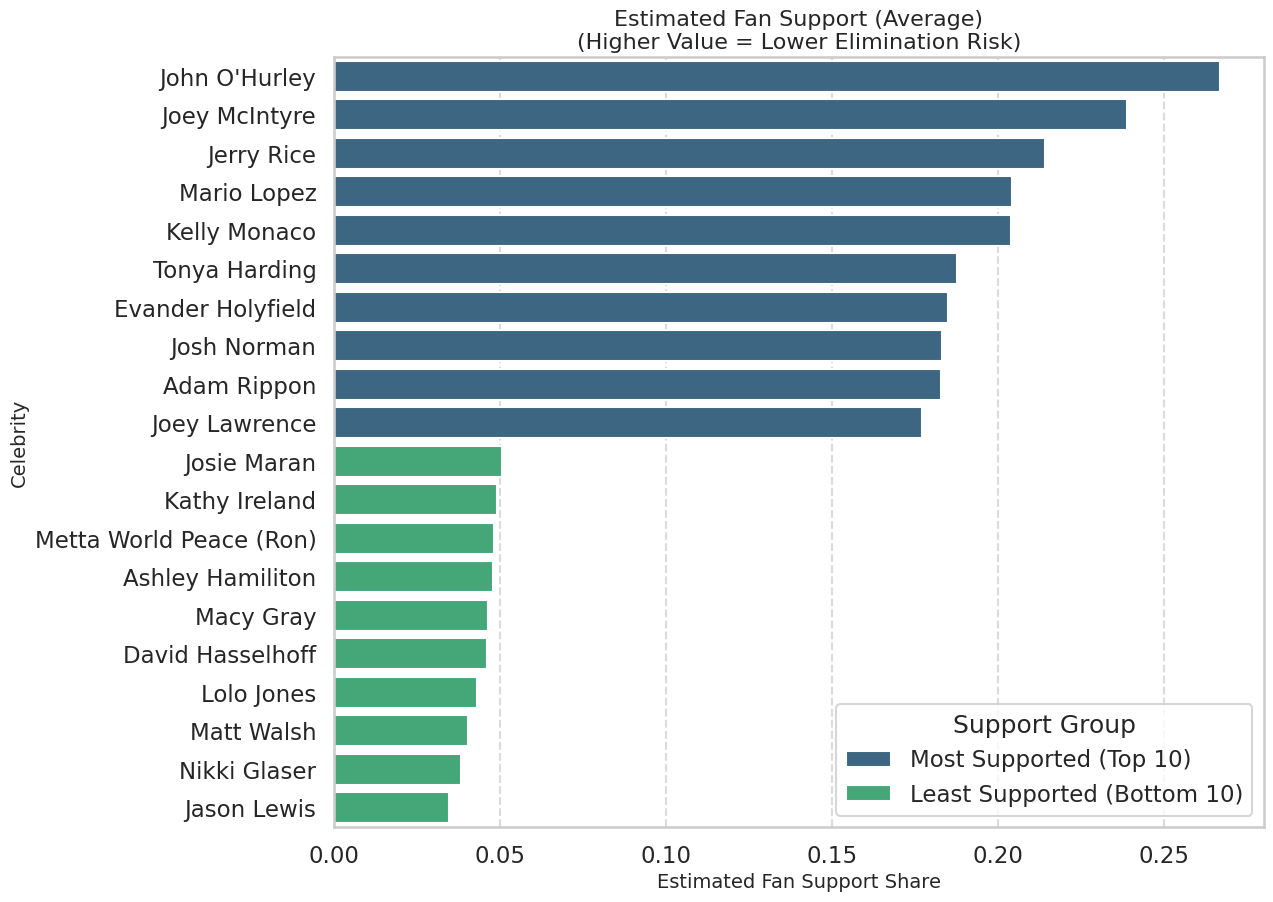

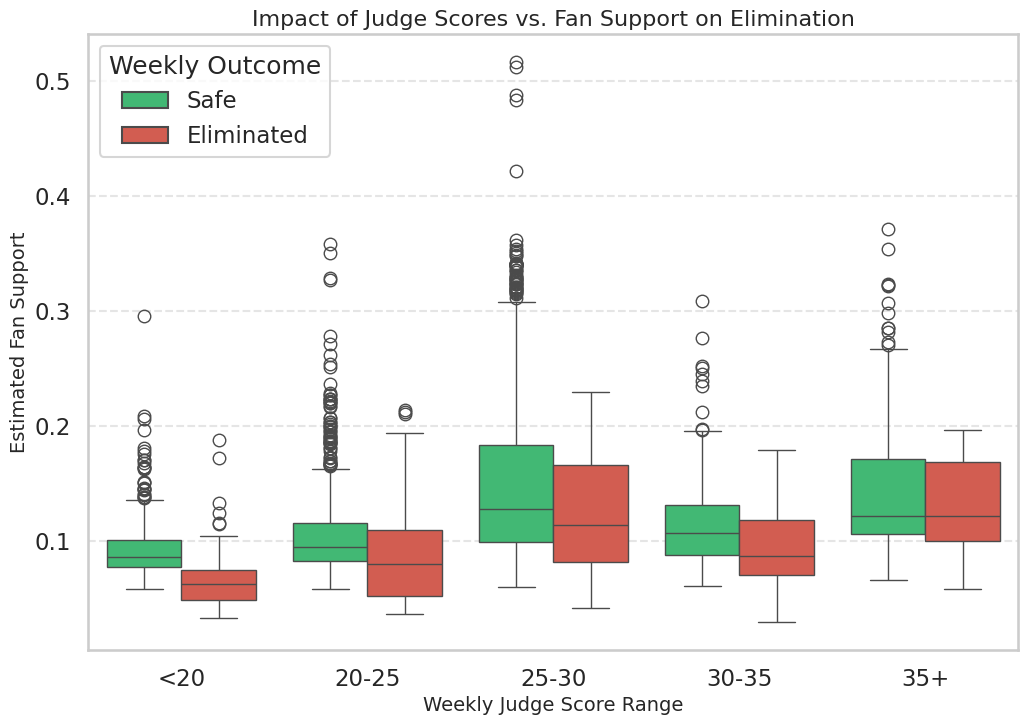

Generating Coefficient Plot...


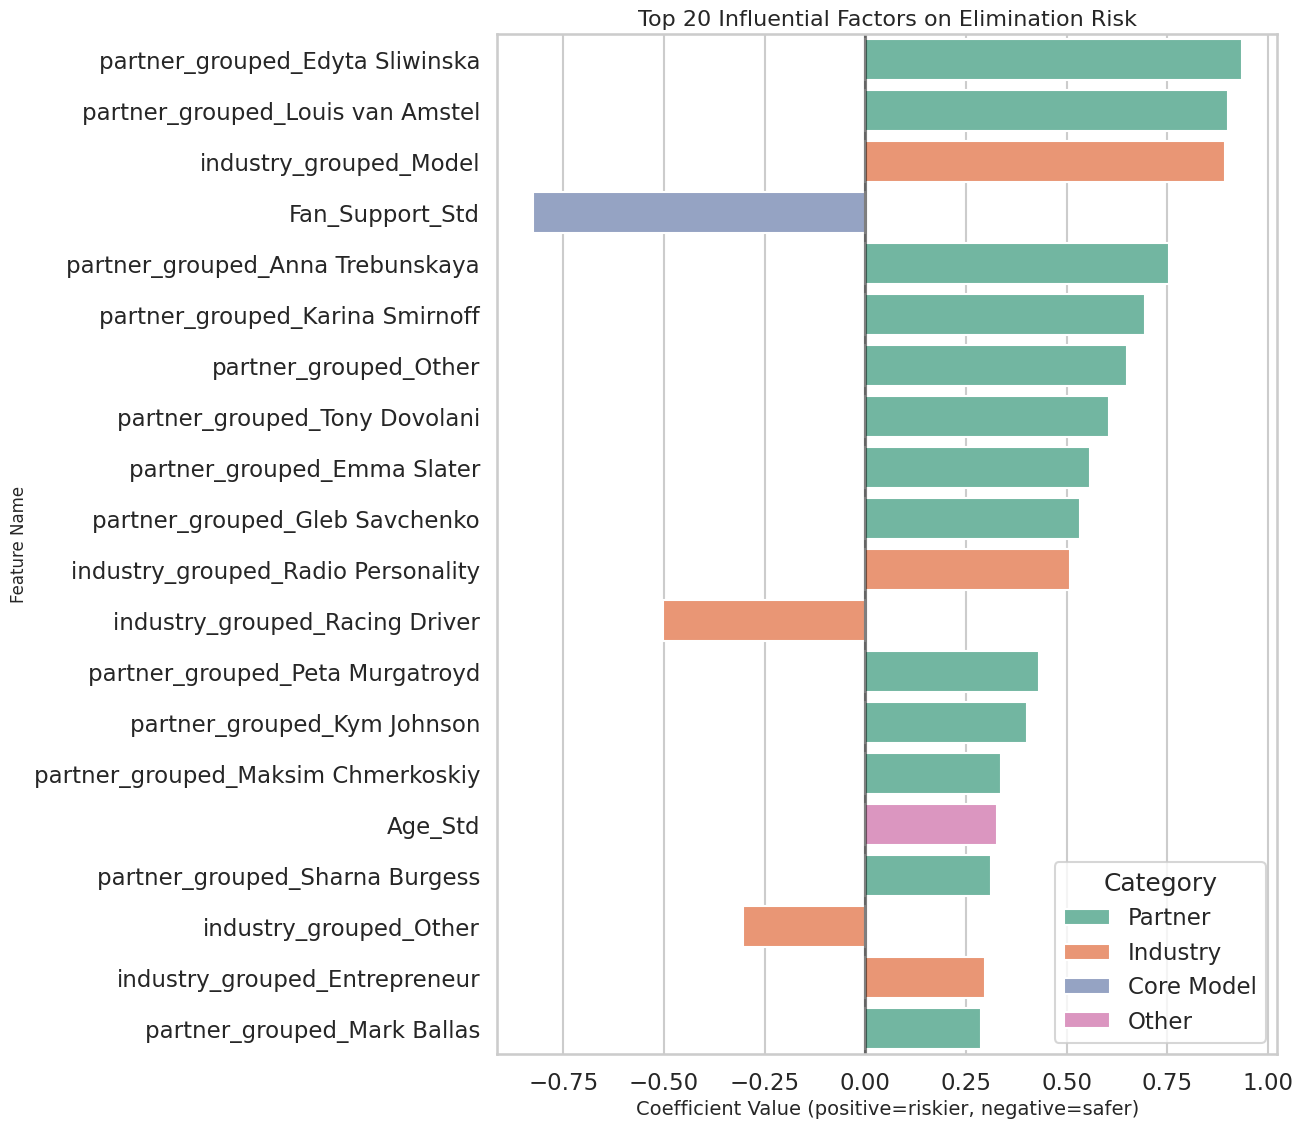

In [90]:
# 5. Visualization of Results (Fixed for New Data)
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Set global style
sns.set_theme(style="whitegrid", context="talk")
plt.rcParams['figure.figsize'] = (14, 8)

# Use the merged dataframe which has the fan votes
plot_data = df_merged.copy()

# --- Plot 1: Top 10 vs Bottom 10 Celebrity Fan Support ---
# Calculate mean fan support per celebrity
celebrity_v = plot_data.groupby('celebrity_name')['Est_Fan_Support'].mean().sort_values(ascending=False)

# Get Top 10 and Bottom 10
top_10 = celebrity_v.head(10)
bottom_10 = celebrity_v.tail(10)

# Combine for plotting
combined_v = pd.concat([top_10, bottom_10])
plot_df = combined_v.reset_index()
plot_df['Group'] = ['Most Supported (Top 10)'] * 10 + ['Least Supported (Bottom 10)'] * 10

plt.figure(figsize=(12, 10))
sns.barplot(data=plot_df, x='Est_Fan_Support', y='celebrity_name', hue='Group', dodge=False, palette='viridis')
plt.title('Estimated Fan Support (Average)\n(Higher Value = Lower Elimination Risk)', fontsize=16)
plt.xlabel('Estimated Fan Support Share', fontsize=14)
plt.ylabel('Celebrity', fontsize=14)
plt.legend(title='Support Group', loc='lower right')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

# --- Plot 2: Relationship between Judge Score & Fan Support ---
plot_data['Score_Group'] = pd.cut(plot_data['judge_score'],
                                   bins=[0, 20, 25, 30, 35, 41],
                                   labels=['<20', '20-25', '25-30', '30-35', '35+'])
plot_data['is_eliminated'] = plot_data['is_eliminated'].astype('category')

custom_palette = {0.0: "#2ecc71", 1.0: "#e74c3c"} # Ensure float keys if y is float

plt.figure(figsize=(12, 8))
try:
    ax = sns.boxplot(
        data=plot_data,
        x='Score_Group',
        y='Est_Fan_Support',
        hue='is_eliminated',
        palette=custom_palette,
        dodge=True
    )

    ax.set_title('Impact of Judge Scores vs. Fan Support on Elimination', fontsize=16)
    ax.set_xlabel('Weekly Judge Score Range', fontsize=14)
    ax.set_ylabel('Estimated Fan Support', fontsize=14)
    # Handle legend accurately
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, ['Safe', 'Eliminated'], title='Weekly Outcome', loc='upper left')

    ax.grid(axis='y', linestyle='--', alpha=0.5)
    plt.show()
except Exception as e:
    print(f"Skipping Plot 2 due to data type issue: {e}")

# --- Plot 3: Coefficient Impact by Category ---
print("Generating Coefficient Plot...")
try:
    # 3.1 Define Categories
    def assign_category(feature_name):
        feature_name = str(feature_name)
        if 'partner' in feature_name: return 'Partner'
        if 'industry' in feature_name: return 'Industry'
        if 'homestate' in feature_name: return 'Home State'
        if 'region' in feature_name: return 'Region'
        if 'age' in feature_name: return 'Demographics'
        if 'Judge' in feature_name: return 'Core Model'
        if 'Fan' in feature_name: return 'Core Model'
        if 'intercept' in feature_name.lower() or 'const' in feature_name.lower(): return 'Baseline'
        return 'Other'

    # Ensure coef_df exists from previous cell
    if 'coef_df' in locals():
        plot_coefs = coef_df.copy()
        plot_coefs['Feature'] = plot_coefs.index
        plot_coefs['Category'] = plot_coefs['Feature'].apply(assign_category)

        # Filter out Intercept/Const
        plot_coefs = plot_coefs[~plot_coefs['Feature'].isin(['const', 'Intercept'])]
        
        # Sort by absolute coefficient size
        plot_coefs['abs_val'] = plot_coefs['Coefficient'].abs()
        top_plot_coefs = plot_coefs.sort_values('abs_val', ascending=False).head(20)

        plt.figure(figsize=(12, 12))
        
        sns.barplot(
            data=top_plot_coefs, 
            y='Feature', 
            x='Coefficient', 
            hue='Category', 
            dodge=False, 
            palette='Set2'
        )
        
        plt.title('Top 20 Influential Factors on Elimination Risk', fontsize=16)
        plt.xlabel('Coefficient Value (positive=riskier, negative=safer)', fontsize=14)
        plt.ylabel('Feature Name', fontsize=12)
        plt.axvline(0, color='black', alpha=0.5, linestyle='-')
        plt.legend(title='Category', loc='lower right')
        plt.subplots_adjust(left=0.3, right=0.95, top=0.95, bottom=0.1)
        plt.show()
    else:
        print("coef_df not found. Run regression cell first.")

except Exception as e:
    print(f"Error visualizing Plot 3: {e}")
